In [265]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from statsmodels.stats.multitest import multipletests

# Define experiments

In [126]:
experiments = {"rpl22_oe": [
    ['LNCaP_GFP_1',
     'LNCaP_GFP_2',
     'LNCaP_GFP_3'],
    ['LNCaP_RPL22_1',
     'LNCaP_RPL22_2',
     'LNCaP_RPL22_3']
],
    "rpl22l1_oe": [
    ['CAL851_GFP_1',
     'CAL851_GFP_2',
     'CAL851_GFP_3'],
    ['CAL851_RPL22L1_1',
     'CAL851_RPL22L1_2',
     'CAL851_RPL22L1_3']
],
    "sh704": [
    ['LNCaP_shLuc_1',
     'LNCaP_shLuc_2',
     'LNCaP_shLuc_3'],
    ['LNCaP_sh704_1',
     'LNCaP_sh704_2',
     'LNCaP_sh704_3']
],
    "sh705": [
    ['LNCaP_shLuc_1',
     'LNCaP_shLuc_2',
     'LNCaP_shLuc_3'],
    ['LNCaP_sh705_1',
     'LNCaP_sh705_2',
     'LNCaP_sh705_3']
]
}

experiment_ids = ["rpl22_oe","rpl22l1_oe","sh704","sh705"]

# Load TPMS and sleuth results

In [74]:
named_tpms = pd.read_hdf("../data/processed/tpm_matrix_named.hdf",key="named_tpms")

rpl22_oe_tpms = pd.read_hdf("../data/intermediate/kallisto_sleuth/RPL22_oe.hdf", key="rpl22_oe")
rpl22l1_oe_tpms = pd.read_hdf("../data/intermediate/kallisto_sleuth/RPL22L1_oe.hdf", key="rpl22l1_oe")
sh704_tpms = pd.read_hdf("../data/intermediate/kallisto_sleuth/sh704.hdf", key="sh704")
sh705_tpms = pd.read_hdf("../data/intermediate/kallisto_sleuth/sh705.hdf", key="sh705")

# Differential expression

In [166]:
def as_si(x, ndp):
    """
    Convert a number to scientific notation

    Parameters
    ----------
    x : float
        number to convert
    ndp: float
        number of decimal places

    Returns
    -------
    x_si : string
        x formatted in scientific notation
    """

    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    x_si = r'{m:s} × $10^{{{e:d}}}$'.format(m=m, e=int(e))

    return x_si

In [302]:
control_color = "grey"
treatment_color = "red"
alpha = 0.5


def plot_tpm_dist(transcript_id, experiment_id, diff_results, ax=None, pal=None, xlabel=None, ylabel=None):

    if ax is None:
        ax = plt.subplot(111)

    if pal is None:
        pal = sns.color_palette([control_color, treatment_color])

    if xlabel is None:
        xlabel = experiment_id

    if ylabel is None:
        ylabel = "mRNA expression, log2(TPM + 1)"

    select_abundance = diff_results.loc[transcript_id]

    controls = experiments[experiment_id][0]
    treatments = experiments[experiment_id][1]

    tpms = np.log2(select_abundance[controls+treatments].astype(np.float64)+1)

    expression_df = pd.DataFrame(index=controls+treatments)

    expression_df["tpm"] = tpms
    expression_df["treatment"] = ["control"] * \
        len(controls)+["treatment"]*len(treatments)

    sns.swarmplot(x="treatment",
                  y="tpm",
                  data=expression_df,
                  ax=ax,
                  palette=pal,
                  s=6,
                  alpha=alpha,
                  edgecolor="black",
                  )

    sns.barplot(x="treatment",
                y="tpm",
                data=expression_df,
                ax=ax,
                palette=pal,
                alpha=alpha/2,
                linewidth=1,
                ci=None
                )

    means = expression_df.groupby("treatment")["tpm"].mean()

    ax.axhline(means["control"], 0.1, 0.4,
               linewidth=2, color="black", zorder=100)
    ax.axhline(means["treatment"], 0.6, 0.9,
               linewidth=2, color="black", zorder=100)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.spines['left'].set_position(('axes', -0.05))

    plt.ylim(0)

    y_max = max(tpms)

    if not np.isnan(select_abundance["qval"]):

        qval = as_si(select_abundance["qval"], 0)
        ax.text(0.5, y_max*1.2, qval, ha="center", fontsize=8)

    return ax, y_max


def plot_tpm_dist_all(transcript_id):

    f, axes = plt.subplots(1, 4, sharey=True, figsize=(4, 3))

    maxes = []

    ax = axes[0]
    ax, y_max = plot_tpm_dist(transcript_id, "rpl22_oe", rpl22_oe_tpms, ax=ax)
    maxes.append(y_max)
    ax.set_xlabel("RPL22++")

    ax = axes[1]
    ax, y_max = plot_tpm_dist(
        transcript_id, "rpl22l1_oe", rpl22l1_oe_tpms, ax=ax, ylabel="")
    maxes.append(y_max)
    ax.spines["left"].set_visible(False)
    ax.tick_params(axis='y', which='both', right=False,
                   left=False, labelleft=False)
    ax.set_xlabel("RPL22L1++")

    ax = axes[2]
    ax, y_max = plot_tpm_dist(transcript_id, "sh704",
                              sh704_tpms, ax=ax, ylabel="")
    maxes.append(y_max)
    ax.spines["left"].set_visible(False)
    ax.tick_params(axis='y', which='both', right=False,
                   left=False, labelleft=False)

    ax = axes[3]
    ax, y_max = plot_tpm_dist(transcript_id, "sh705",
                              sh705_tpms, ax=ax, ylabel="")
    maxes.append(y_max)
    ax.spines["left"].set_visible(False)
    ax.tick_params(axis='y', which='both', right=False,
                   left=False, labelleft=False)

    plt.ylim(-0.1, max(maxes)*1.25)

    plt.subplots_adjust(wspace=0.4)

    legend_elements = [Line2D([0], [0], marker='o', color="white", label='Control',
                              markerfacecolor=control_color, markersize=8, alpha=alpha),
                       Line2D([0], [0], marker='o', color="white", label='Treatment',
                              markerfacecolor=treatment_color, markersize=8, alpha=alpha)]

    plt.legend(handles=legend_elements,
               loc='upper left', bbox_to_anchor=(1, 1))

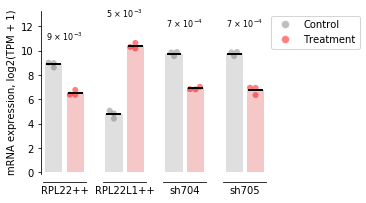

In [303]:
plot_tpm_dist_all("ENST00000463836.1")

# Differential splicing

In [251]:
rpl22_oe_exons = pd.read_hdf("../data/processed/exon_psi_diffs/RPL22_oe.hdf", key="rpl22_oe")
rpl22l1_oe_exons = pd.read_hdf("../data/processed/exon_psi_diffs/RPL22L1_oe.hdf", key="rpl22l1_oe")
sh704_exons = pd.read_hdf("../data/processed/exon_psi_diffs/sh704.hdf", key="sh704")
sh705_exons = pd.read_hdf("../data/processed/exon_psi_diffs/sh705.hdf", key="sh705")

In [268]:
def plot_psi_dist(exon_id, experiment_id, diff_results, ax=None, pal=None, xlabel=None, ylabel=None):

    if ax is None:
        ax = plt.subplot(111)

    if pal is None:
        pal = sns.color_palette([control_color, treatment_color])

    if xlabel is None:
        xlabel = experiment_id

    if ylabel is None:
        ylabel = "mRNA expression, log2(TPM + 1)"

    select_abundance = diff_results.loc[exon_id]

    controls = experiments[experiment_id][0]
    treatments = experiments[experiment_id][1]

    tpms = np.log2(select_abundance[controls+treatments].astype(np.float64)+1)

    expression_df = pd.DataFrame(index=controls+treatments)

    expression_df["tpm"] = tpms
    expression_df["treatment"] = ["control"] * \
        len(controls)+["treatment"]*len(treatments)

    sns.swarmplot(x="treatment",
                  y="tpm",
                  data=expression_df,
                  ax=ax,
                  palette=pal,
                  s=6,
                  alpha=alpha,
                  linewidth=1,
                  edgecolor="black",
                  )
    
    means = expression_df.groupby("treatment")["tpm"].mean()
    
    ax.axhline(means["control"], 0.15,0.35, linewidth=2, color="black", zorder=100)
    ax.axhline(means["treatment"], 0.65,0.85, linewidth=2, color="black", zorder=100)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.spines['left'].set_position(('axes', -0.05))
    
    plt.ylim(0)
    
    y_max = max(tpms)
    
    if not np.isnan(select_abundance["qval"]):
    
        qval = as_si(select_abundance["qval"],0)
        ax.text(0.5, y_max*1.2, qval,ha="center",fontsize=8)

    return ax, y_max


In [272]:
rpl22_oe_exons["qval"] = multipletests(rpl22_oe_exons["pval"], alpha=0.01, method="fdr_bh")[1]

KeyError: 'qval'

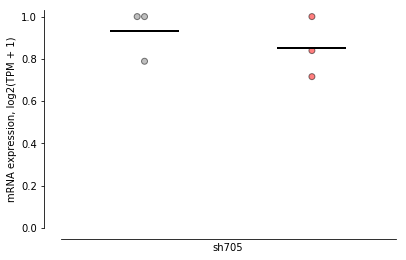

In [281]:
plot_psi_dist("ENSG00000198625;SE:1:204532246-204537459:204537497-204538209:+","sh705",sh705_exons)

In [ ]:
rpl22_oe_exons["qval"] = rpl22_oe_exons["pval"]

In [287]:
rpl22_oe_exons[rpl22_oe_exons["gene_names"].apply(lambda x: "MDM4" in x)]

,difference,pval,type,LNCaP_GFP_1,LNCaP_GFP_2,LNCaP_GFP_3,LNCaP_RPL22_1,LNCaP_RPL22_2,LNCaP_RPL22_3,gene_names,qval
Event_id,,,,,,,,,,,
ENSG00000198625;A3:1:204532246-204537430:204532246-204537459:+,-0.169158,0.070929,A3,0.717680,0.822244,0.754712,0.506379,0.607380,0.673405,MDM4,0.79777
ENSG00000198625;AL:1:204538308-204542784:204542931:204538308-204546797:204546834:+,-0.135927,0.204795,AL,1.000000,1.000000,1.000000,1.000000,0.592219,1.000000,MDM4,0.79777
ENSG00000198625;MX:1:204525596-204526360:204526434-204538209:204525596-204537459:204537497-204538209:+,NaN,1.000000,MX,0.000000,0.000000,NaN,0.000000,NaN,NaN,MDM4,1.00000
ENSG00000198625;SE:1:204532246-204537430:204537497-204538209:+,-0.491305,0.004995,SE,1.000000,1.000000,1.000000,0.303315,0.506652,0.716118,MDM4,0.79777
ENSG00000198625;SE:1:204532246-204537459:204537497-204538209:+,-0.584274,0.015485,SE,1.000000,1.000000,1.000000,0.297950,0.398984,0.550245,MDM4,0.79777
ENSG00000198625;SE:1:204532246-204538209:204538308-204546797:+,NaN,1.000000,SE,NaN,NaN,NaN,NaN,1.000000,NaN,MDM4,1.00000
ENSG00000198625;SE:1:204538308-204542784:204542944-204546797:+,NaN,1.000000,SE,1.000000,NaN,NaN,1.000000,0.000000,NaN,MDM4,1.00000
ENSG00000198625;SE:1:204542944-204544535:204544684-204546797:+,-0.010293,0.330170,SE,0.791074,1.000000,0.910475,0.782167,0.905547,0.982955,MDM4,0.79777
